In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 87.8 MB/s eta 0:00:00


In [2]:
# import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

In [3]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-02 17:45:44--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.003s  

2026-01-02 17:45:45 (10.7 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-02 17:45:45--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [4]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [21]:
print(train_X.shape)
print(train_y)



(16, 256)
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


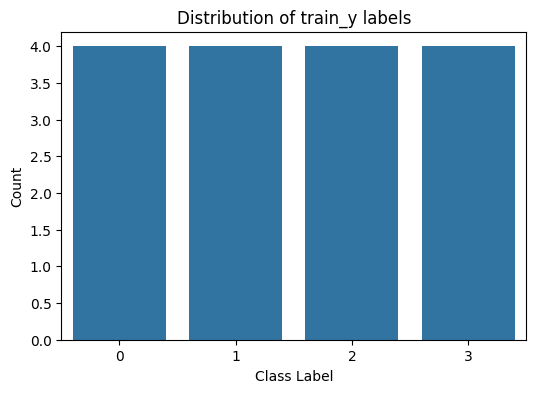

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_y
plt.figure(figsize=(6, 4))
sns.countplot(x=train_y)
plt.title('Distribution of train_y labels')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

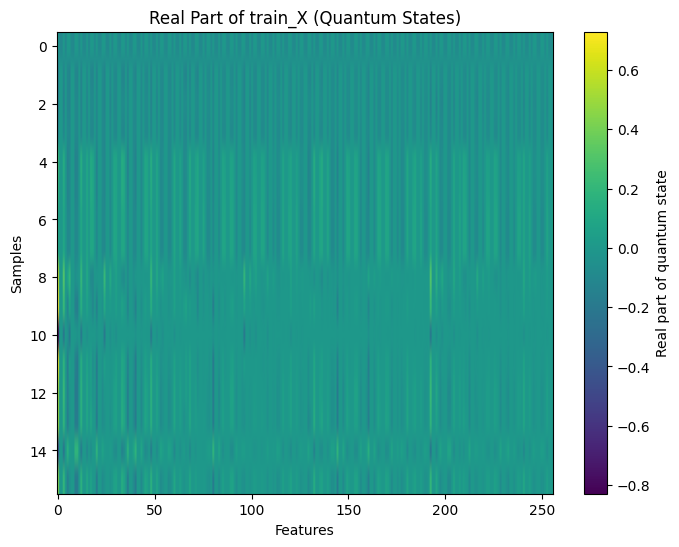

In [15]:
# Plot the real part of train_X as an image
plt.figure(figsize=(8, 6))
plt.imshow(np.real(train_X), cmap='viridis', aspect='auto')
plt.colorbar(label='Real part of quantum state')
plt.title('Real Part of train_X (Quantum States)')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [5]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [63]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

def Quantum_classifier(params):
    wires = [i for i in range(n_qubits)]
    params = params.reshape(-1,3,8)
    for layer in range(params.shape[0]-1):
        for i, wire in enumerate(wires):
            qml.Rot(params[layer,0,i], params[layer,1,i], params[layer,2,i], wires=wire)
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
    for i, wire in enumerate(wires):
        qml.Rot(params[-1,0,i], params[-1,1,i], params[-1,2,i], wires=wire)



@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    wires = [i for i in range(n_qubits)]
    qml.StatePrep(state, wires=wires)
    Quantum_classifier(params)

    return qml.probs(wires=[6,7])
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.total_params = 5*3*8  # 15 layers, 3 params per qubit, 8 qubits
        torch.manual_seed(42)
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True)*0.01)

    def forward(self, x):
        preds = linear_2qubit_block(x, self.params)
        return preds

model = QNN()
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.05)


epochs = 100
loss_history = []
acc_history = []
print(f"--- Training QNN (Params: {model.total_params}) ---")

def quantum_phase_loss(probs, labels):
    """
    Custom Loss Function based on Eq. (10) of the paper.
    Loss = 1 - (Probability of the correct class)
    """
    # probs shape: (batch_size, 4)
    # labels shape: (batch_size,)


    batch_size = probs.shape[0]

    # 정답 인덱스의 확률 추출 (Advanced Indexing)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs
    probs = probs / torch.sum(probs, dim=1, keepdim=True)

    loss = -torch.sum(label_one_hot*torch.log(probs), dim=1)

    # 배치 평균 반환
    return torch.mean(loss)


for epoch in range(epochs):
    total_loss = 0
    correct = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X.to(device=device))
        loss = quantum_phase_loss(predictions, batch_y.to(device=device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

--- Training QNN (Params: 120) ---


In [30]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 환경 설정
n_qubits = 8
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 양자 회로 설계
def Quantum_block(params):
    # params shape: (n_layers, 3, n_qubits)
    for layer in range(params.shape[0]):
        # Rotation Layer
        for i in range(n_qubits):
            qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)

        # Entangling Layer (Ring topology)
        if layer < params.shape[0] - 1:
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    # inputs: (256,) 형태의 정규화된 데이터
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 마지막 2개 큐비트의 확률 측정 -> 2^2 = 4 클래스
    return qml.probs(wires=[6, 7])
    # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. 모델 클래스
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 가중치를 (layers, 3, n_qubits) 형태로 직접 선언
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)
        self.post_process = nn.Linear(n_qubits, 4)

    def forward(self, x):
        # batch 데이터를 qnode에 적용 (vmap 또는 반복문 처리)
        # PennyLane-Torch 인터페이스는 batch 입력을 지원합니다.
        return qnode(x, self.params)
        # q_out = qnode(x, self.params)
        # q_out = torch.stack(q_out, dim=1).float() # (batch_size, 8)

        # logits = self.post_process(q_out)
        # return logits

# 4. 데이터 준비 (예시)
# train_x: (16, 256), train_y: (16,)
train_x = torch.randn(16, 256)
# !! 중요 !! Amplitude Embedding을 위한 정규화
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True)
train_y = torch.tensor([0, 1, 2, 3] * 4) # 예시 레이블

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. 학습 설정
model = QNN(n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # 수치적으로 안정적인 Loss

# # 6. 학습 루프
# epochs = 100
# for epoch in range(epochs):
#     avg_loss = 0
#     correct = 0
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#         optimizer.zero_grad()
#         # forward 시 qml.probs 결과값은 (batch, 4)
#         predictions = model(batch_X)

#         # log_softmax를 취해주는 것이 CrossEntropyLoss 사용 시 좋습니다.
#         # qml.probs는 확률이므로 log를 직접 취하거나 모델 끝에 epsilon을 더해줌
#         loss = criterion(torch.log(predictions + 1e-10), batch_y)

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() / len(train_loader)
#         predicted_classes = torch.argmax(predictions, dim=1)
#         correct += (predicted_classes == batch_y).sum().item()

#     avg_acc = correct / len(train_dataset)
#     if (epoch + 1) % 20 == 0:
#         print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

In [59]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block(params):
    for layer in range(params.shape[0]):
        # Rotation Layer
        for i in range(n_qubits):
            qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        if layer % 2 == 1: # 징검다리 얽힘 추가
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 2) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: 1.1180 | Train Acc: 0.9375
Epoch 40 | Loss: 1.0740 | Train Acc: 1.0000
Epoch 60 | Loss: 1.0439 | Train Acc: 1.0000
Epoch 80 | Loss: 1.0175 | Train Acc: 1.0000
Epoch 100 | Loss: 1.0093 | Train Acc: 1.0000
Epoch 120 | Loss: 1.0048 | Train Acc: 1.0000
Epoch 140 | Loss: 1.0018 | Train Acc: 1.0000
Epoch 160 | Loss: 1.0013 | Train Acc: 1.0000
Epoch 180 | Loss: 0.9990 | Train Acc: 1.0000
Epoch 200 | Loss: 0.9978 | Train Acc: 1.0000
Epoch 220 | Loss: 0.9967 | Train Acc: 1.0000
Epoch 240 | Loss: 0.9965 | Train Acc: 1.0000
Epoch 260 | Loss: 0.9959 | Train Acc: 1.0000
Epoch 280 | Loss: 0.9952 | Train Acc: 1.0000
Epoch 300 | Loss: 0.9940 | Train Acc: 1.0000


In [26]:
# 8개의 큐비트 설정 (2^8 = 256 features)
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(weights, features):
    # 1. Data Embedding: 256개의 특성을 8개 큐비트에 인코딩
    # features는 반드시 정규화(L2 norm = 1) 되어 있어야 합니다.
    qml.AmplitudeEmbedding(features=features, wires=range(n_qubits), normalize=True)

    # 2. Variational Layers: 학습 가능한 레이어
    # StronglyEntanglingLayers는 회전 게이트와 Entanglement를 반복하여 표현력을 높입니다.
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # 3. Measurement: 4개의 클래스 분류를 위해 4개 큐비트의 PauliZ 기대값 측정
    # 결과값은 [-1, 1] 사이의 값 4개가 반환됩니다.
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# 가중치 초기화 (layers=3, qubits=8, parameters=3)
num_layers = 3
weight_shapes = {"weights": (num_layers, n_qubits, 3)}
weights = np.random.random(size=(num_layers, n_qubits, 3))

In [27]:
print("Circuit Output:", quantum_circuit(weights, train_X))

Circuit Output: [array([-0.02015968,  0.00360085,  0.00147896,  0.00312414,  0.03938334,
        0.04236908,  0.05150625,  0.05092688,  0.095527  ,  0.11175903,
        0.1865054 ,  0.09169802,  0.04642806,  0.05029141,  0.04666019,
        0.04256894]), array([ 0.01867096,  0.05170682,  0.05745953,  0.03347366, -0.06505187,
       -0.06669841, -0.06208547, -0.06271148,  0.18795899,  0.14789784,
        0.3037672 ,  0.09293248,  0.00624197,  0.00226897,  0.00135718,
       -0.01438194])]


(<Figure size 5600x900 with 1 Axes>, <Axes: >)

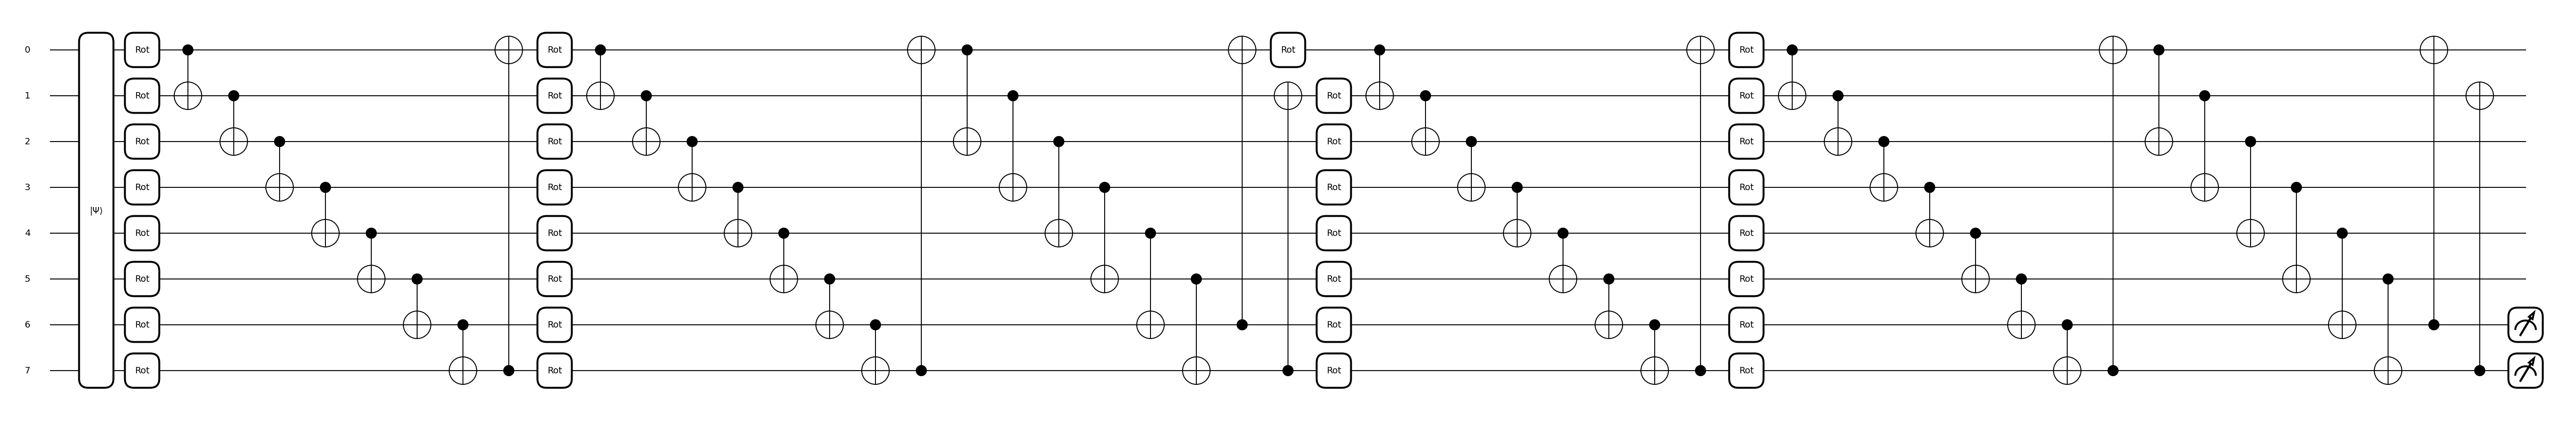

In [49]:
qml.draw_mpl(qnode)(batch_X,model.params)

In [57]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_block(params)

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))


with open("./baseline.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 2834 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(-0.06516304) q[0];
ry(0.3462135) q[0];
rz(-0.13970903) q[0];
rz(-0.0028311252) q[1];
ry(-0.007906777) q[1];
rz(0.020150498) q[1];
✅ Submission file 'baseline.json' created.


qreg q[8];
creg c[8];
rz(0.40498495) q[0];
ry(0.15300891) q[0];
rz(0.46771476) q[0];
rz(0.23690376) q[1];
ry(0.093031146) q[1];
rz(0.2598675) q[1];

In [46]:
from google.colab import files
files.download('baseline.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>